In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
from tqdm import tqdm

In [120]:
model = YOLO('../yolov8s.pt')

In [122]:
centers: list = []    # Bounding Boxes
image = None
CONF_THRESHOLD: float = 0.3
counter: int = 0
frame_count: int = 0
take_every_k_frame: int = 24

# Capture Video
cap = cv2.VideoCapture("../data/raw/test_video.mov")

while(cap.isOpened()):
    ret, frame = cap.read()
    # If no frame is available, break while loop
    if ret == False:
        break
    if image is None:
        image = frame

    # Take every 24th frame
    counter += 1
    if counter % take_every_k_frame != 0:
        continue

    # Transform BGR image to RGB image and predict on given frame
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = model.predict(frame, classes=[0], conf=CONF_THRESHOLD, verbose=False)
    for r in results:
        boxes = r.boxes
        for box in boxes:
            b = box.xyxy[0]     # Get box coordinates in (top, left, bottom, right) format
            c = box.cls     # Get Classification label
            conf = round(box.conf.numpy()[0], 2)    # Round confidence to 2 decimal places
            x0, y0, x1, y1 = b
            x, y, w, h = x0, y0, x1-x0, y1-y0
            center: tuple = (int(x + w/2), int(y1))     # Get shoe position (center)
            centers.append(center)

    # Track how many frames were taken
    frame_count += 1


cap.release()
cv2.destroyAllWindows()

In [123]:
densities = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
for center in tqdm(centers):
    size = (30, 30)
    angle = 0
    startAngle = 0
    endAngle = 360
    density = np.zeros((image.shape[0], image.shape[1]), dtype=np.float32)
    cv2.ellipse(density, center, size, angle, startAngle, endAngle, (1, 1), -1)
    densities = densities + density
# Postprocess densities / heatmap
densities = cv2.GaussianBlur(densities, (21, 21), 0)
densities = cv2.normalize(densities, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
heatmap = cv2.applyColorMap(densities, cv2.COLORMAP_TURBO)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
img = cv2.addWeighted(image, 0.5, heatmap, 1, 0)

100%|██████████| 1196/1196 [00:12<00:00, 96.85it/s]


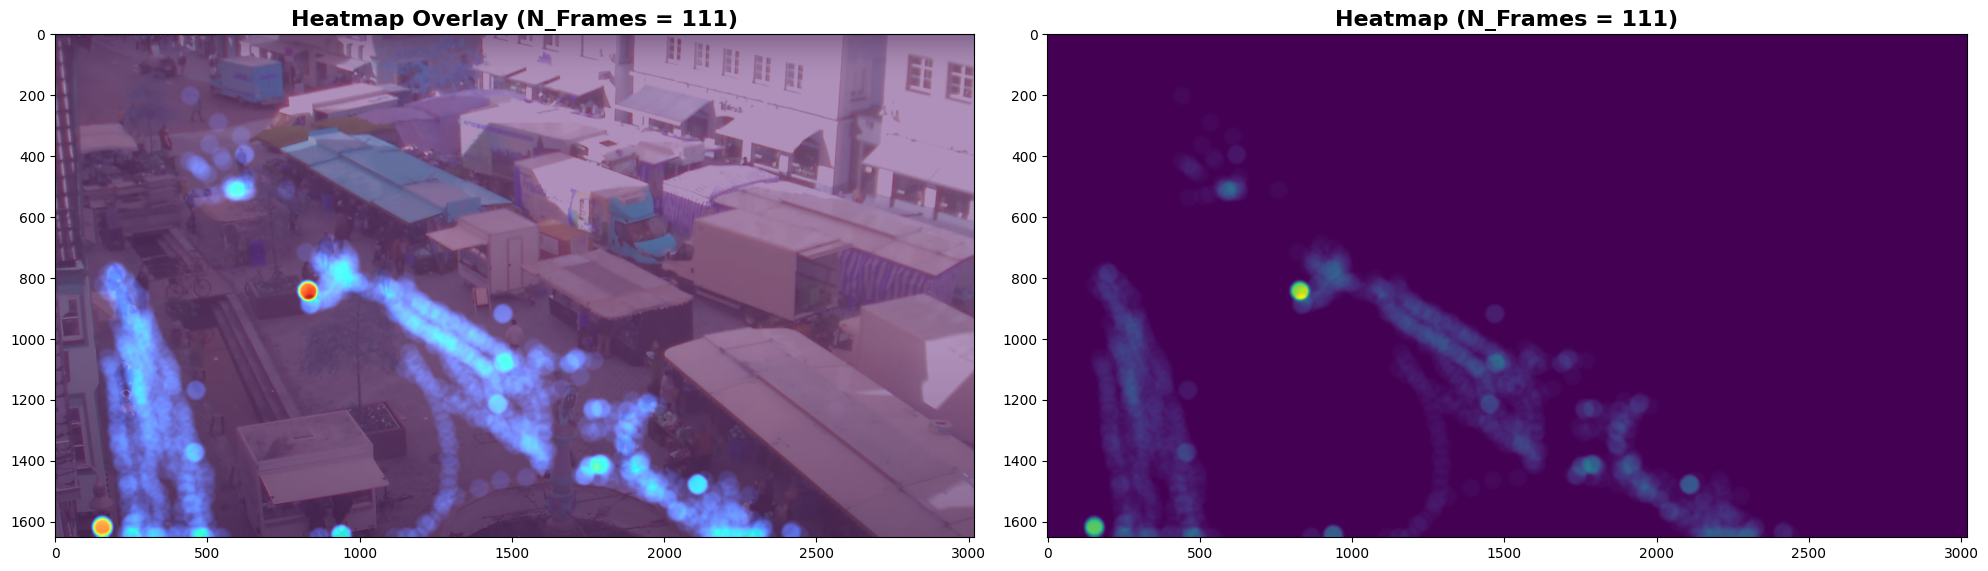

In [124]:
def plot_densities(img: np.array, densities: np.array, frame_count: int) -> None:
    """ Plots the densities / heatmap as a two axis plot
    First axis shows the heatmap overlayed on the first input image;
    Second axis show the heatmap only.

    :param img: np.array -- Image with heatmap overlay (Result of cv2.addWeighted(image, heatmap))
    :param densities: np.array -- Image of heatmap
    :return: None
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    axes[0].imshow(img)
    axes[0].set_title(f"Heatmap Overlay (N_Frames = {frame_count})", size=16, fontweight="bold")
    axes[1].imshow(densities)
    axes[1].set_title(f"Heatmap (N_Frames = {frame_count})", size=16, fontweight="bold")
    fig.tight_layout()
    #plt.savefig("../assets/heatmap.png", dpi=126, bbox_inches='tight')
    plt.show()

plot_densities(img, densities, frame_count)